## Step 1: Imports


In [92]:
import pandas as pd
import kagglehub
import math 
import numpy as np 
import datetime
import matplotlib.pyplot as plt
from matplotlib import style 
style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing, svm, model_selection
from sklearn.linear_model import LinearRegression

In [93]:
df = pd.read_csv('WIKI_PRICES.csv')

## Step 2: Understand The Data

In [94]:
print(df.shape[0]) 
print(df.shape[1])

15389314
14


In [95]:
df.isnull().sum()

ticker           0
date             0
open           538
high            55
low             55
close            1
volume           0
ex-dividend      0
split_ratio      1
adj_open       538
adj_high        55
adj_low         55
adj_close        1
adj_volume       0
dtype: int64

In [96]:
df.dtypes

ticker          object
date            object
open           float64
high           float64
low            float64
close          float64
volume         float64
ex-dividend    float64
split_ratio    float64
adj_open       float64
adj_high       float64
adj_low        float64
adj_close      float64
adj_volume     float64
dtype: object

In [97]:
df.describe()

,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
count,1.538878e+07,1.538926e+07,1.538926e+07,1.538931e+07,1.538931e+07,1.538931e+07,1.538931e+07,1.538878e+07,1.538926e+07,1.538926e+07,1.538931e+07,1.538931e+07
mean,7.652829e+01,7.724188e+01,7.577329e+01,7.653463e+01,1.192647e+06,2.202309e-03,1.000185e+00,1.679133e+02,1.706558e+02,1.650796e+02,1.678707e+02,1.412932e+06
std,2.511524e+03,2.526096e+03,2.494656e+03,2.511146e+03,8.406732e+06,2.145488e-01,2.078999e-02,5.231340e+03,5.331112e+03,5.130088e+03,5.230613e+03,6.535418e+06
min,1.000000e-03,2.000000e-03,1.000000e-03,2.000000e-03,0.000000e+00,0.000000e+00,1.750000e-03,7.109100e-03,7.870789e-03,7.109100e-03,7.870789e-03,0.000000e+00
25%,1.197000e+01,1.217000e+01,1.175000e+01,1.197000e+01,3.850000e+04,0.000000e+00,1.000000e+00,6.130212e+00,6.250000e+00,6.010335e+00,6.130321e+00,4.680000e+04
50%,2.325000e+01,2.362000e+01,2.290000e+01,2.325000e+01,1.866460e+05,0.000000e+00,1.000000e+00,1.387851e+01,1.410171e+01,1.363224e+01,1.387932e+01,2.321000e+05
75%,3.945000e+01,3.995000e+01,3.892000e+01,3.946000e+01,7.174000e+05,0.000000e+00,1.000000e+00,2.809588e+01,2.851000e+01,2.766000e+01,2.809650e+01,9.072000e+05
max,3.256500e+05,3.263500e+05,3.231000e+05,3.259150e+05,6.674913e+09,5.679717e+02,5.000000e+01,8.702400e+05,9.232800e+05,8.545200e+05,8.785200e+05,2.304019e+09


In [98]:
for column in df.columns:
    print(f"{column} : {len(df[column].unique())}")

ticker : 3199
date : 14277
open : 124876
high : 267980
low : 274874
close : 123164
volume : 1678767
ex-dividend : 2163
split_ratio : 125
adj_open : 7137032
adj_high : 7209700
adj_low : 7215091
adj_close : 7039021
adj_volume : 1978562


## Step 3: Clean And Prepare The Data

In [99]:
dataframe = df[['adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume']]

In [100]:
dataframe = dataframe.rename(columns={'adj_open':'open', 'adj_high':'high', 'adj_low':'low', 'adj_close':'close', 'adj_volume':'volume'})

In [101]:
dataframe['volatilityPercentage'] = (dataframe['open'] - dataframe['close']) / dataframe['close'] * 100.0
dataframe['percentageChange'] = (dataframe['close'] - dataframe['open']) / dataframe['open'] * 100.0

In [102]:
df = dataframe[['close', 'volatilityPercentage', 'percentageChange', 'volume']]

In [103]:
df.fillna(-99999, inplace= True)

In [104]:
df.dropna(inplace= True)

In [105]:
df.head()

,close,volatilityPercentage,percentageChange,volume
0,30.018590,3.409091,-3.296703,44739900.0
1,27.548879,6.339772,-5.961807,10897100.0
2,30.018590,-6.113636,6.511740,4705200.0
3,27.460188,5.590062,-5.294118,4274400.0
4,28.012803,-2.264978,2.317468,3464400.0


## Machine Learning

In [106]:
forecastCol = 'close'
forecastOut = int(math.ceil(0.000001 * len(df)))

In [107]:
df['label'] = df[forecastCol].shift(-forecastOut)

In [108]:
df.dropna(inplace= True)

In [109]:
x = np.array(df.drop(['label'],axis= 1))
x = preprocessing.scale(x)
xLately = x[-forecastOut:]
x = x[:-forecastOut:]

In [110]:
y = np.array(df['label'])
y = np.array(df['label'])

In [111]:

df.dropna(inplace=True)

x = np.array(df.drop(['label'], axis=1))
x = preprocessing.scale(x)
y = np.array(df['label'])

xTrain, xTest, yTrain, yTest = model_selection.train_test_split(x, y, test_size=0.2)

In [112]:
clf = LinearRegression()

clf.fit(xTrain, yTrain)

accuracy = clf.score(xTest, yTest)

print(accuracy) 


0.9734313624311548


In [113]:
forecastSet = clf.predict(xLately)

In [114]:
print(forecastSet)
print(accuracy)
print(forecastOut)

[21.38145069 21.0557234  21.30701787 22.37100593 22.20554194 22.20636513
 21.40278887 21.62685293 21.92052252 22.36839808 22.65646854 21.89210627
 21.80791797 21.80739693 22.32762691 22.46111624]
0.9734313624311548
16


In [115]:
df['forecast'] = np.nan

In [116]:
last_date = df.iloc[-1].name
last_unix = datetime.datetime.fromtimestamp(last_date).timestamp() if isinstance(last_date, (int, np.integer)) else last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

In [117]:
for i in forecastSet:
    next_date = datetime.datetime. fromtimestamp(next_unix)
    next_unix += one_day
    df. loc [next_date] = [np.nan for _ in range(len (df. columns) - 1)] + [i]

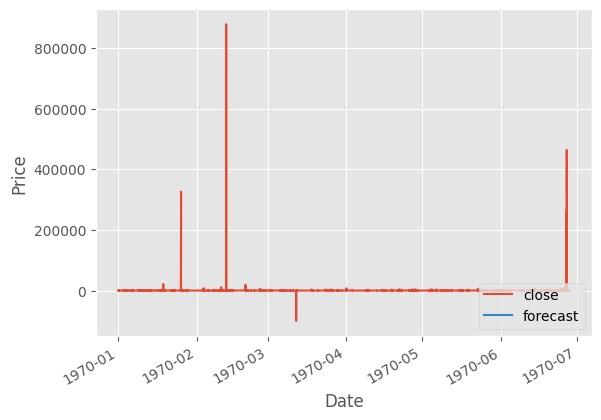

In [118]:
# Ensure the index is a proper DatetimeIndex with the correct unit
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, unit='s', errors='coerce')  # Assuming the index is in seconds

# Re-run the plotting code to visualize the data
df['close'].plot()
df['forecast'].plot()

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
